# Getting Started with THRML

Extropic hardware will become increasingly capable over the next few years. If everything goes to plan, our first ~million variable chips will come online in 2026 and be integrated into large many-chip systems by 2027. These systems will be capable of complex probabilistic computations and could offer a substantial edge to anyone who knows how to wield them.

Given these (relatively) short timelines to large-scale commercial viability, businesses must start working today to adapt our tech to their use cases. To enable this, we built a software library that simulates Extropic hardware devices on traditional machine learning accelerators like GPUs. Users can leverage this library to explore how future Extropic systems could be used to accelerate workloads they care about.

Our simulation library, THRML, is a GPU simulator of the probabilistic sampling programs that run natively on Extropic hardware. It is built on top of JAX and is massively scalable, enabling users to simulate arbitrarily large probabilistic computing systems given sufficient GPU resources.

## What's a probabilistic computer?

Probabilistic computers leverage arrays of massively parallel random number generators to sample from distributions that are relevant to solving practical problems. By leveraging physical effects to generate random numbers and emphasising local communication, probabilistic computers can process information extremely efficiently. 

These sampling-centric computers make direct contact with contemporary machine learning via *Energy Based Models* (EBMs). Much like popular diffusion models and autoregressive language models, EBMs attempt to learn the probability distribution that underlies some observations of the world. However, EBMs are unique in that they try to directly learn the shape of this distribution instead of attempting to represent it via the composition of many much simpler distributions. This direct fitting of data distributions leads to training and inference pipelines that are extremely sampling-heavy. While these sampling-heavy workloads can challenge traditional machine learning accelerators, they present a massive opportunity for probabilistic computers.

In particular, symmetries of certain families of EBMs can be leveraged to map EBM sampling problems directly onto probabilistic computing hardware, unlocking ultra-efficient EBM training and inference. We leveraged these symmetries, along with other hardware and algorithm innovations, to demonstrate that probabilistic computers can be many orders of magnitude more energy-efficient than GPUs [in our recent paper](https://arxiv.org/abs/2510.23972).


## How do Extropic's probabilistic computers work?

To truly understand how Extropic's probabilistic computers operate and their utility in machine learning, we must examine the underlying mathematics of EBMs and the algorithms that enable probabilistic computers to sample from them.

EBMs attempt to model data distributions by learning a parameterized *Energy Function* $\mathcal{E}(x, \theta)$ that defines the shape of the model's probability distribution,

$$ \mathbb{P}(X = x) \propto e^{-\mathcal{E}(x, \theta)}$$

Here, $X$ is a vector of random variables that represents the data you want to model, which could be text, images, etc. EBMs are fit by tweaking the model's parameters $\theta$ to assign low values of energy to values of $x$ that show up in the dataset and large values of energy to values of $x$ that don't. 

For EBMs, both inference and training involve sampling from this potentially very complex probability distribution, which is very expensive to do on a CPU or GPU. At inference time, we aim to generate new data that resembles the dataset, which requires drawing samples from the learned distribution. During training, to estimate gradients of the typical EBM training objective with respect to the parameters $\theta$, one needs to compute estimators of certain averages over the EBM's distribution, which means lots of sampling. If a probabilistic computer can make this sampling very efficient, it could dramatically improve the real-world performance of EBMs relative to other types of machine learning models.

Extropic's probabilistic computers can efficiently sample from *factorized* EBMs that contain only *local* interactions. An EBM is factorized if its energy function splits up into a sum over independent terms,

$$ \mathcal{E}(x)  = \sum_{(\psi, x_1, \dots, x_N) \in S} \psi \left( x_1, \dots, x_N \right) $$

where $S$ is the set of all the factors involved in the EBM. Each member of $S$ consists of a factor energy function $\psi$ that acts on a subset of the model's variables $x_1, \dots, x_N$. A factor is *local* if it only involves variables that are somehow "close" to each other, which in the context of a probabilistic computer means that they are embodied by circuitry that lives on nearby parts of a chip.

Extropic's probabilistic computers leverage the Gibbs sampling algorithm to efficiently sample from these special EBMs. Gibbs sampling is a procedure in which samples are drawn from the EBM's distribution by iteratively updating blocks of non-interacting variables according to their conditional distributions.

$$ \mathbb{P}(X_i = x_i| X_{nb(i)} = x') \propto e^{-\mathcal{E}_i(x_i, x')}$$

where $X_{nb(i)}$ is the set of random variables that $X_i$ interacts with and $\mathcal{E}_i$ contains contributions from the set of factors that involve the state of $X_i$, which we denote as $S_i$,

$$ \mathcal{E}_i(x_i, x') = \sum_{(\psi, x_1, \dots, x_K) \in S_i} \psi \left(x_i, x_1, \dots, x_K \right) $$

Extropic's probabilistic computers implement this block Gibbs sampling procedure at the hardware level to dramatically reduce the energy cost of EBM training and inference.

## A concrete example

To make all of this more concrete, here we will implement a simulation of a simple probabilistic computer sampling from an EBM using THRML.

We will implement sampling for a *Potts Model*, which is a type of EBM that was first developed to study various phenomena in solid-state physics. Potts models have energy functions like,

$$ \mathcal{E}(x) = -\beta \left( \sum_i W^{(1)}_i [x_i] + \sum_{(i, j) \in S} W^{(2)}_{i, j} [x_i, x_j] \right)$$

Here, $x_i$ is an integer representing a possible state of a categorical random variable. The vector $W^{(1)}_{i}$ induces a bias on the $i^{th}$ variable by adding or subtracting energy based on the value of $x_i$. The matrix $W^{(2)}_{i, j}$ generates an interaction between the $i^{th}$ and $j^{th}$ variables by contributing a term to the energy function that depends on both $x_i$ and $x_j$.
 
Let's use THRML to run block Gibbs sampling on a Potts model.

First, some imports that will be useful,

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from thrml.block_management import Block
from thrml.block_sampling import BlockGibbsSpec, sample_states, SamplingSchedule
from thrml.pgm import CategoricalNode
from thrml.models.discrete_ebm import CategoricalEBMFactor, CategoricalGibbsConditional
from thrml.factor import FactorSamplingProgram

The Potts model energy function naturally suggests a graphical interpretation. Namely, we can assign each random variable in the problem to a node, and assign biases to each node to implement the $W^{(1)}$. We can connect variables with edges to represent the interactions $W^{(2)}$.

As such, let's define a simple graph to use in our problem,

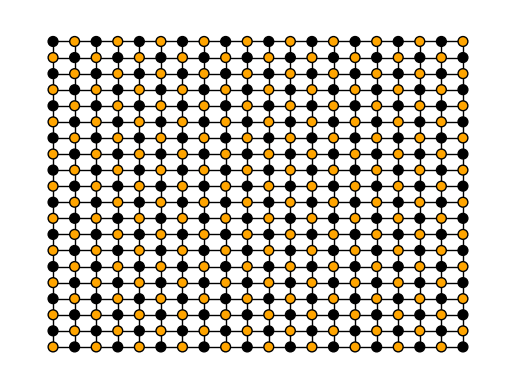

In [3]:
side_length = 20

# in this simple example we will just use a basic grid, although THRML is capable of dealing with arbitrary graph topologies
G = nx.grid_graph(dim=(side_length, side_length), periodic=False)

# label the nodes with something THRML recognizes for convenience
coord_to_node = {coord: CategoricalNode() for coord in G.nodes}
nx.relabel_nodes(G, coord_to_node, copy=False)
for coord, node in coord_to_node.items():
    G.nodes[node]["coords"] = coord

# write down the color groups for later
bicol = nx.bipartite.color(G)
color0 = [n for n, c in bicol.items() if c == 0]
color1 = [n for n, c in bicol.items() if c == 1]

# write down the edges in a different format for later
u, v = map(list, zip(*G.edges()))

# plot the graph
pos = {n: G.nodes[n]["coords"][:2] for n in G.nodes}
colors = ["black", "orange"]
node_colors = [colors[bicol[n]] for n in G.nodes]

fig, axs = plt.subplots()

nx.draw(
    G,
    pos=pos,
    ax=axs,
    node_size=50.0,
    node_color=node_colors,
    edgecolors="k",
    with_labels=False,
)

The graph we just drew can be interpreted as a high-level schematic for a probabilistic computer. Each node is associated with specialized circuitry for performing the Gibbs sampling conditional update, which requires state information from neighboring nodes that is communicated along the edges (which could represent physical wires). Nodes of the same color can be updated in parallel, which means that a single iteration of Gibbs sampling can be performed by first updating all of the orange nodes simultaneously, followed by all of the blue nodes.

Now that we have our graph, we can define the interactions that make up the energy function we described earlier. THRML comes with a canned implementation of Potts model style interactions in `thrml.models` that we can leverage here. We will consider a simple case that is commonly studied in physics with no biases and identity coupling matrices.

In [4]:
# how many categories to use for each variable
n_cats = 5

# temperature parameter
beta = 1.0


# implements W^{2} for each edge
# in this case we are just using an identity matrix, but this could be anything
id_mat = jnp.eye(n_cats)
weights = beta * jnp.broadcast_to(jnp.expand_dims(id_mat, 0), (len(u), *id_mat.shape))
coupling_interaction = CategoricalEBMFactor([Block(u), Block(v)], weights)

interactions = [coupling_interaction]

We can use these interactions to build a sampling program! THRML exposes tools that we can use to very easily run the Gibbs sampling algorithm for our problem.

For our Potts model, we will need to update our state using a conditional distribution with the energy function,

$$ \mathcal{E}_i(x_i, x') = -\beta \left( W^{(1)}_i [x_i] + \sum_{j \in S_i} W^{(2)}_{i, j} [x_i, x_j] \right)$$

This corresponds to sampling from a *softmax* distribution. THRML comes pre-packaged with this conditional, which we will leverage to perform our sampling:

In [5]:
# first, we have to specify a division of the graph into blocks that will be updated in parallel during gibbs sampling
# During gibbs sampling, we are only allowed to update nodes in parallel if they are not neighbours
# Mathematically, this means we should choose our sampling blocks based on the "minimum coloring" of the graph
# we already computed this earlier

# a Block of nodes is simply a sequence of nodes that are all the same type
# we only have one type of node here, so not important to understand yet
blocks = [Block(color0), Block(color1)]

# our grouping of the graph into blocks
spec = BlockGibbsSpec(blocks, [])

# we have to define how each node in our blocks should be updated during each iteration of Gibbs sampling
# THRML comes with a sampler that will do this for the vanilla potts model we are using here, so lets use that
sampler = CategoricalGibbsConditional(n_cats)

# now we can make a sampling program, which combines our grouping with the interactions we defined earlier
prog = FactorSamplingProgram(
    spec,  # our block decomposition of the graph
    [sampler for _ in spec.free_blocks],  # how to update the nodes in each block every iteration of Gibbs sampling
    interactions,  # the interactions present in our model
    [],
)

That's everything! Now we can simply run our sampling program and observe the results,

In [6]:
# rng seed
key = jax.random.key(4242)

# everything in THRML is completely compatible with standard jax functionality like jit, vmap, etc.
# here we will use vmap to run a bunch of parallel instances of Gibbs sampling
n_batches = 100

# we need to initialize our Gibbs sampling instances
init_state = []
for block in spec.free_blocks:
    key, subkey = jax.random.split(key, 2)
    init_state.append(
        jax.random.randint(subkey, (n_batches, len(block.nodes)), minval=0, maxval=n_cats, dtype=jnp.uint8)
    )

# how we should schedule our sampling
schedule = SamplingSchedule(
    # how many iterations to do before drawing the first sample
    n_warmup=0,
    # how many samples to draw in total
    n_samples=100,
    # how many steps to take between samples
    steps_per_sample=5,
)

keys = jax.random.split(key, n_batches)

# now run sampling
samples = jax.jit(jax.vmap(lambda i, k: sample_states(k, prog, schedule, i, [], [Block(G.nodes)])))(init_state, keys)

If we look at the results of our sample, we are able to observe domain formation, which is a very famous property of Potts models. Domain formation happens because our diagonal weight matrix encourages neighbouring variables to match,, leading to the formation of *domains* where groups of neighbouring variables are all in the same state. 

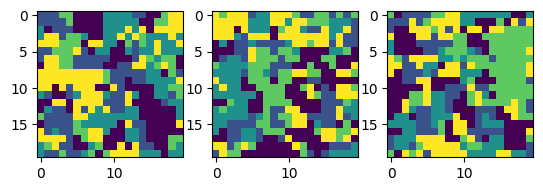

In [7]:
to_plot = [0, 7, 21]

fig, axs = plt.subplots(nrows=1, ncols=len(to_plot))

for i, num in enumerate(to_plot):
    axs[i].imshow(samples[0][num, -1, :].reshape((side_length, side_length)))

Despite its apparent simplicity, this example gets at the heart of why EBMs can be used as powerful machine learning primitives. Even though our model only involves simple interactions between neighbouring variables, it produces complex emergent long-range correlations that are difficult to predict and understand. By learning the weights of a model like this (instead of just setting them to be the identity matrix), we can take advantage of this capacity for complexity to model complex real-world phenomena, and do so using very little energy by leveraging probabilistic computing hardware.


We've only scratched the surface of what can be done with THRML in this simple example. While here we mostly leaned on canned functionality built into THRML, in reality, THRML was designed from the ground up to make it easier for users to implement their own entirely novel probabilistic graphical model block-sampling routines. We designed it this way because probabilistic computing is a rapidly changing field. So it's essential to have flexible tools available to you that minimize exploratory friction.

The other examples in this repo will begin to explore some of the more advanced functionality THRML offers. If you are interested in using THRML for your own research, we encourage you to check it out.

Suppose you want to learn more about how hardware-compatible EBMs may be applied to real machine learning problems. In that case, you should check out [our paper](http://arxiv.org/abs/2510.23972) and an [implementation of it in `THRML`](https://github.com/pschilliOrange/dtm-replication). Our primary hope for this library is that it empowers its users to build on our work, developing progressively more complex machine learning systems that increasingly leverage ultra-efficient probabilistic computing.